In [1]:
# Matrix Manipulation
import numpy as np
import pandas as pd

# Utility operations
from numpy import log as ln
import math
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Saving objects
import pickle
from functools import partial

# Utility Functions

In [2]:
class HDCModels():
    @classmethod
    def save_model(self, model, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_model(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class ItemMemories():
    @classmethod
    def save_IM(self, im, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(im, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_IM(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class SparseHDC():
    # Cyclic shifts the input hypervector arr by shift_count
    @classmethod
    def cyclic_shift(self, arr, shift_count=1):
        return np.concatenate((arr[-shift_count:],arr[:-shift_count]))
    
    @classmethod
    def dot(self, hv1, hv2):
        return np.sum(np.logical_and(hv1, hv2))
    
    @classmethod
    def disp(self, hv):
        s = math.sqrt(len(hv))
        if (s-int(s)):
            return "Must be square"
        
        return np.array(hv).reshape(int(s),int(s))

    # Generate a random sparse HV with dimension and sparsity
    @classmethod
    def generate_random_sparse_HV(self, dim = 10000, sparsity=0.3):
        percent_sparsity = int(100*sparsity)
        return np.vectorize(SparseHDC._generation_threshold)(np.random.randint(101,size=dim), percent_sparsity)
    
    # Generate count number of sparse HVs with dimension and sparsity
    @classmethod
    def generate_random_sparse_HVs(self, count=10, dim = 10000, sparsity=0.3):
        return [SparseHDC.generate_random_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # Generate a sparse HV with exact sparsity
    @classmethod
    def generate_sparse_HV(self, dim=10000, sparsity=0.3):
        hv = np.repeat(0,dim)
        hv[random.sample(range(1,dim),int(sparsity*dim))]=1
        return hv
    
    # Generate count number of sparse HV with dimension and exact sparsity
    @classmethod
    def generate_sparse_HVs(self, count=10, dim=10000, sparsity=0.3):
        return [SparseHDC.generate_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # PRIVATE METHODS
    
    # Returns 1 if num < percent_sparsity where 0<=num<=100
    @classmethod
    def _generation_threshold(self, num, percent_sparsity = 30):
        return 1 if num<percent_sparsity else 0

# Datasets

In [3]:
class ISOLET():
    def __init__ (self, train_filepath = 'isolet1+2+3+4.csv', test_filepath = 'isolet5.csv'):
        self.train = pd.read_csv(train_filepath, header=None)
        self.train_X = self.train[[i for i in range(0,617)]]
        self.train_y = self.train[617]
        self.test = pd.read_csv(test_filepath, header=None)
        self.test_X = self.test[[i for i in range(0,617)]]
        self.test_y = self.test[617]

class ItemMemory():
    def __init__(self, cim, base_hvs):
        self.cim = cim
        self.base_hvs = base_hvs

# Sparsifiers

In [4]:
# Sparsifying Method

class ThresholdingSparsifier():
    def __init__(self, percent_max_val=0.3, max_val=617):
        self.percent_max_val = percent_max_val
        self.max_val = max_val
    
    def sparsify(self, hv):
        return np.array((hv>self.threshold())).astype(np.int)
    
    def threshold(self):
        return int(self.percent_max_val*self.max_val)

In [5]:
class HoloGNEncoder():
    def __init__(self, dim, sparsity, M, ENC_THR, shift_range_multiplier=1, base_hvs=None):
        self.dim = dim
        self.sparsity = sparsity
        self.M = M
        self.qlevels = self.quantization_levels(M)
        self.shifts = random.sample(range(0,int(M*shift_range_multiplier)),M) #np.arange(0,M)
        self.base_hvs = np.array(SparseHDC.generate_sparse_HVs(dim=dim, sparsity=sparsity, count=617)) if base_hvs is None else base_hvs
        self.sparsifier = ThresholdingSparsifier(percent_max_val = ENC_THR/617, max_val=617)
        
    def encode(self, features, return_acc=False):
        shifts = np.vectorize(self.get_shift)(features)
        shifted_base_hvs = pd.Series(map(SparseHDC.cyclic_shift, self.base_hvs, shifts))
        acc = np.sum(shifted_base_hvs)
        thr = self.sparsifier.sparsify(acc)
        return acc if return_acc else thr

    def quantization_levels(self, M, min_val=-1, max_val=1, precision=5):
        step = (max_val - min_val) / (M-1)
        qlevels = list(np.arange(min_val, max_val+(0.1*step), step).round(precision))
        return qlevels

    def get_shift(self, value):
        closest_value = min(self.qlevels, key=lambda x:abs(x-value))
        return self.shifts[self.qlevels.index(closest_value)]

# TESTING SETUP

In [6]:
# TEST DATA VARIABLES

isolet = ISOLET()

# Rows in each class
class_indexes = {}
classes = range(1,27)
for class_ in classes:
    class_indexes[class_] = list(isolet.train_y[isolet.train_y==class_].index)

# Rows for each class
# class_rows[class_no][sample_no], class_no corresponds to A-Z but 1-26 instead
class_rows = {}
for class_ in classes:
    class_rows[class_] = np.array(list(isolet.train_X.loc[class_indexes[class_]].itertuples(index=False, name=None)))

# 10 rows for each class
test_class_rows = {}

for class_, rows in class_rows.items():
    test_class_rows[class_] = rows[0:10]

In [7]:
def plot_sparsity_vs_encoding_threshold(encoder, test_class_rows, interval=[0,100]):
    dim = encoder.dim
    for class_ in test_class_rows.keys():
        for row in test_class_rows[class_]:
            sample_encode = encoder.encode(row, return_acc = True)

            sparsity_values = []
            for i in range(interval[0], interval[1]+1):
                sp = ThresholdingSparsifier(percent_max_val=i/100)
                sparsity_values.append(np.sum(sp.sparsify(sample_encode))/dim)

            plt.plot(range(interval[0], interval[1]+1), sparsity_values)

    plt.title("Sparsity vs Percent Threshold (Component Sparsity ~ {})".format(encoder.sparsity))
    plt.ylabel("sparsity")
    plt.xlabel("threshold (% of component count)")

# RUN TESTS HERE
### Please run the setup cells before testing as well as the library class (all the previous cells)
## For 617 accumulated Sparse HVs, what must be the threshold value to yield the desired sparsity?

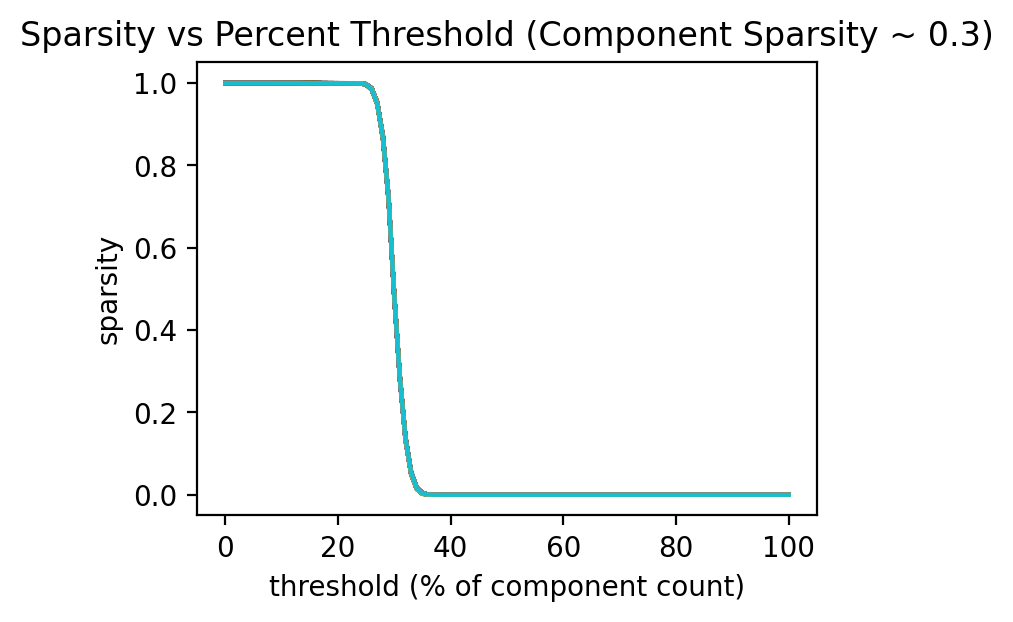

In [8]:
encoder = HoloGNEncoder(dim=10000, sparsity=0.30, M=2, ENC_THR=9)
figure(figsize=(4,3), dpi=200)
plot_sparsity_vs_encoding_threshold(encoder=encoder, test_class_rows=test_class_rows, interval=[0,100])

Mean number of ones: 2849.7615384615383


<AxesSubplot:>

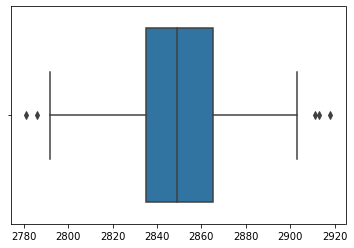

In [12]:
no_of_ones = []
encoder.sparsifier.percent_max_val = 191/617
for class_ in classes:
    for row in test_class_rows[class_]:
        no_of_ones.append( np.sum(encoder.encode(row)) )

print("Mean number of ones: {}".format(np.average(np.array(no_of_ones))))
sns.boxplot(x=no_of_ones)